In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct, sum as spark_sum, max as spark_max, datediff, lit
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
spark = SparkSession.builder.appName("RFM_KMeans").getOrCreate()

df1 = pd.read_csv('Transactions.csv', parse_dates=['Date'])
df2 = pd.read_csv('Products_with_Categories.csv')
df = pd.merge(df1, df2, on='productId', how='left').fillna(0)
#  Chuyển đổi Pandas DataFrame thành PySpark DataFrame
df_spark = spark.createDataFrame(df)

C:\Users\Admin\AppData\Local\Temp\ipykernel_23764\1423222255.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df1 = pd.read_csv('Transactions.csv', parse_dates=['Date'])


In [4]:
df_spark = df_spark.withColumn("Date", col("Date").cast("date"))
max_date = df_spark.select(spark_max("Date")).collect()[0][0]

df_spark = df_spark.withColumn("gross_sales", col("price") * col("items"))

In [5]:
df_rfm = df_spark.groupBy("Member_number").agg(
    datediff(lit(max_date), spark_max("Date")).alias("Recency"),
    countDistinct("productId").alias("Frequency"),
    spark_sum("gross_sales").alias("Monetary") 
)

In [6]:
df_rfm = df_rfm.dropna()
# Chuẩn hóa dữ liệu với VectorAssembler
assembler = VectorAssembler(inputCols=["Recency", "Frequency", "Monetary"], outputCol="features", handleInvalid="skip")
df_rfm_vector = assembler.transform(df_rfm)

# Chuẩn hóa dữ liệu bằng StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_rfm_vector)
df_rfm_scaled = scaler_model.transform(df_rfm_vector)

In [7]:
#  Chọn số cụm K bằng Elbow Method
costs = []
ks = range(2, 10)

for k in ks:
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=42)
    model = kmeans.fit(df_rfm_scaled)
    costs.append(model.summary.trainingCost)

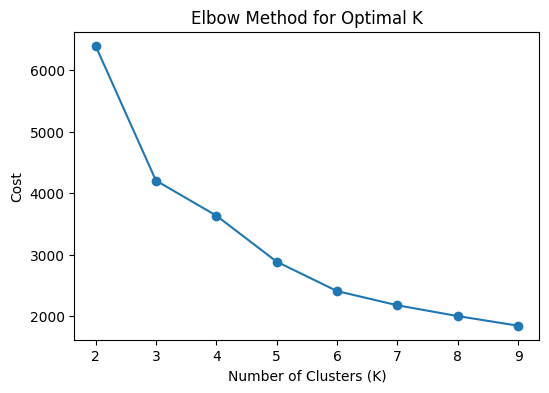

In [8]:
#  Vẽ đồ thị Elbow
plt.figure(figsize=(6,4))
plt.plot(ks, costs, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal K')
plt.show()

In [12]:
optimal_k = 5
kmeans = KMeans(featuresCol="scaled_features", k=optimal_k, seed=42)
model = kmeans.fit(df_rfm_scaled)
df_rfm_clustered = model.transform(df_rfm_scaled)

In [13]:
df_rfm_clustered.select("Member_number", "Recency", "Frequency", "Monetary", "prediction").show(10)

+-------------+-------+---------+------------------+----------+
|Member_number|Recency|Frequency|          Monetary|prediction|
+-------------+-------+---------+------------------+----------+
|         1697|     43|       14|             78.66|         1|
|         2509|    168|        7|             105.1|         1|
|         2040|    173|       15|             140.0|         0|
|         2453|      9|       14|            114.69|         1|
|         1806|    206|        9|            109.22|         4|
|         3764|     80|       11| 70.80000000000001|         1|
|         2927|    303|       10| 60.36000000000001|         4|
|         2250|     76|        8|              73.4|         1|
|         1677|    109|       11|219.00000000000006|         0|
|         1950|     49|        8|             43.35|         3|
+-------------+-------+---------+------------------+----------+
only showing top 10 rows



In [14]:
df_rfm_clustered.groupBy("prediction").agg(
    {"Recency": "mean", "Frequency": "mean", "Monetary": "mean"}
).show()

+----------+------------------+------------------+------------------+
|prediction|      avg(Recency)|     avg(Monetary)|    avg(Frequency)|
+----------+------------------+------------------+------------------+
|         1| 71.22097378277154| 91.67627340823972|10.131086142322097|
|         3|140.95356037151703| 41.91200206398351| 5.273477812177503|
|         4| 280.8492201039861| 96.30318890814569|10.013864818024263|
|         2|471.60446570972886|35.960382775119605| 4.417862838915471|
|         0| 88.84779299847793|175.83339421613383|15.659056316590563|
+----------+------------------+------------------+------------------+



In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [16]:
df_rfm_pd = df_rfm_clustered.select("Recency", "Frequency", "Monetary", "prediction").toPandas()

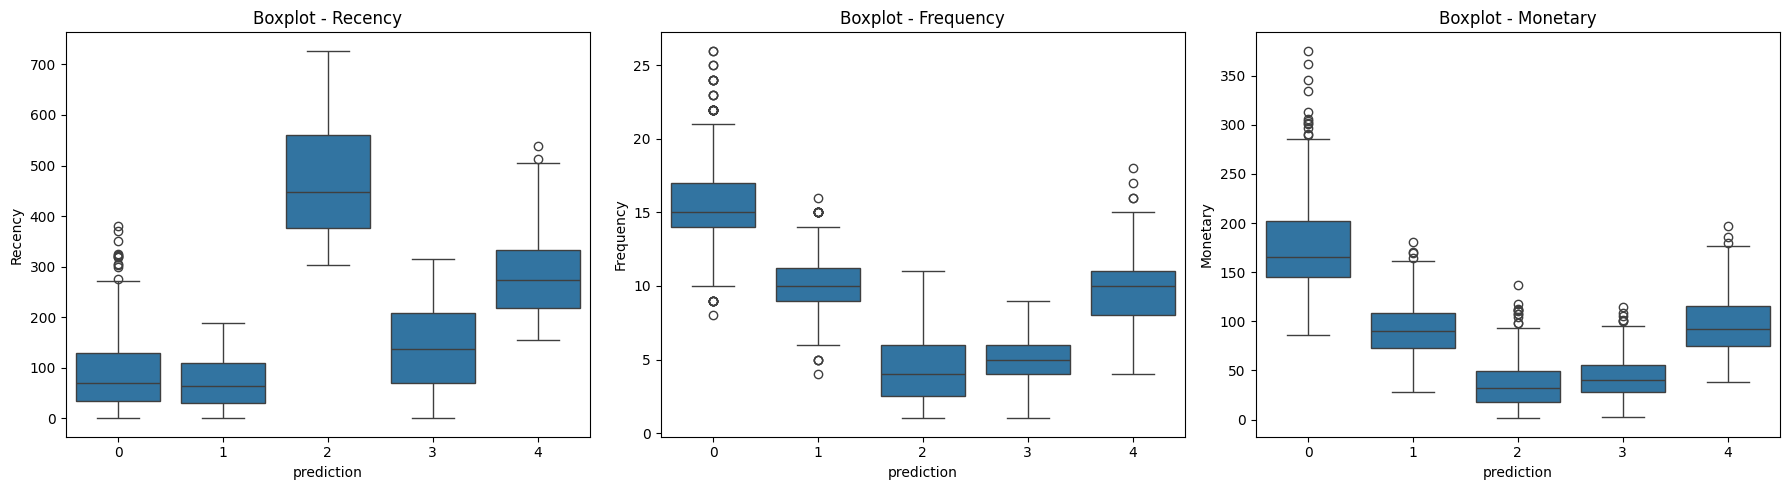

In [17]:
# Boxplot cho từng giá trị RFM theo cụm
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x="prediction", y="Recency", data=df_rfm_pd, ax=axes[0])
axes[0].set_title("Boxplot - Recency")

sns.boxplot(x="prediction", y="Frequency", data=df_rfm_pd, ax=axes[1])
axes[1].set_title("Boxplot - Frequency")

sns.boxplot(x="prediction", y="Monetary", data=df_rfm_pd, ax=axes[2])
axes[2].set_title("Boxplot - Monetary")

plt.tight_layout()
plt.show()

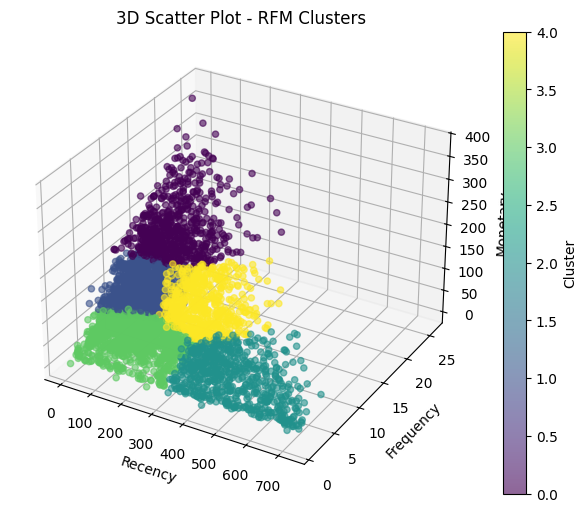

In [18]:
#  3D Scatter Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Tạo scatter plot
scatter = ax.scatter(df_rfm_pd["Recency"], df_rfm_pd["Frequency"], df_rfm_pd["Monetary"], 
                     c=df_rfm_pd["prediction"], cmap="viridis", alpha=0.6)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("3D Scatter Plot - RFM Clusters")

# Thêm chú thích
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()

# Nhận Xét :
    - Cluster 0 là nhóm khách hàng VIP, tần suất mua nhiều nhất và chi tiêu cao nhất. Nên có chương trình chăm sóc đặc biệt.

    - Cluster 1 là nhóm khách hàng có tần suất mua tốt, chi tiêu khá. Nên duy trì và kích thích mua sắm thêm.

    - Cluster 2 là nhóm khách hàng đã lâu không quay lại. Cần chiến lược tiếp cận lại họ (email marketing, giảm giá, quà tặng).

    - Cluster 3 có tần suất mua thấp và cũng không chi tiêu nhiều. Nhóm này có thể ít quan tâm đến sản phẩm.

    - Cluster 4 từng là khách hàng trung thành nhưng đã lâu không mua. Cần nhắc nhở, có thể là khách hàng tiềm năng nếu kích thích mua lại.

